# Model Visualization Notebook

This notebook demonstrates how each of our three models works by showing:

1. XGBoost model with facial landmarks
2. ResNet model for eye state classification
3. Custom CNN model for drowsiness detection


In [5]:
import os
import sys
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import dlib
import xgboost as xgb
from PIL import Image
from torchvision import transforms, models
from scipy.spatial import distance
import joblib
from loguru import logger
import random
import glob

In [6]:
def get_random_samples(base_path, num_samples=2):
    """Get random samples from a directory."""
    all_files = glob.glob(os.path.join(base_path, "*"))
    return random.sample(all_files, min(num_samples, len(all_files)))

In [7]:
def calculate_eye_aspect_ratio(eye_points):
    a = distance.euclidean(eye_points[1], eye_points[5])
    b = distance.euclidean(eye_points[2], eye_points[4])
    c = distance.euclidean(eye_points[0], eye_points[3])
    return 0 if c == 0 else (a + b) / (2.0 * c)


def calculate_mouth_aspect_ratio(mouth_points):
    a = distance.euclidean(mouth_points[2], mouth_points[10])
    b = distance.euclidean(mouth_points[3], mouth_points[9])
    c = distance.euclidean(mouth_points[4], mouth_points[8])
    d = distance.euclidean(mouth_points[0], mouth_points[6])
    return 0 if d == 0 else (a + b + c) / (3.0 * d)


def detect_landmarks(
    image_path, predictor_path="../inputs/utils/shape_predictor_68_face_landmarks.dat"
):
    image = cv2.imread(image_path)
    if image is None:
        logger.error(f"Could not load image {image_path}")
        return None, None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    faces = detector(gray, 1)

    if not faces:
        logger.warning(f"No faces found in {image_path}")
        return None, None

    landmarks = predictor(gray, faces[0])
    points = np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(68)])

    # Draw landmarks on image
    for i in range(68):
        cv2.circle(
            image, (landmarks.part(i).x, landmarks.part(i).y), 2, (0, 255, 0), -1
        )

    return image, points


def plot_image_with_title(image, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


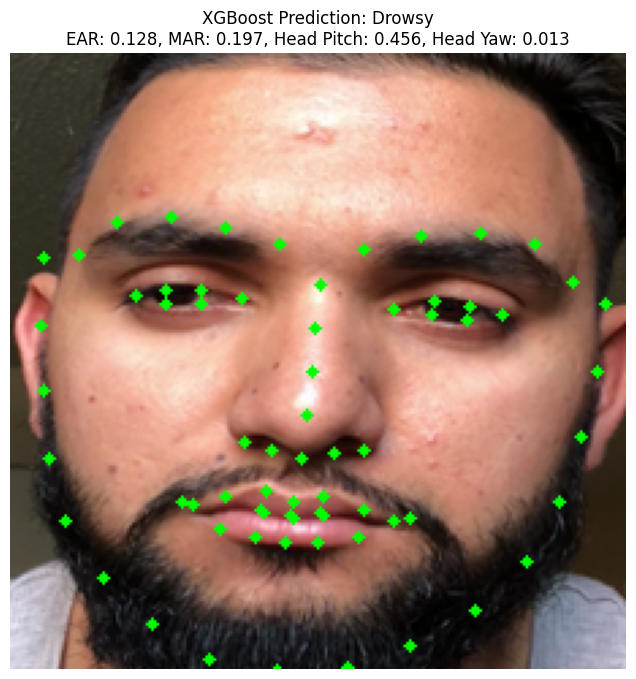

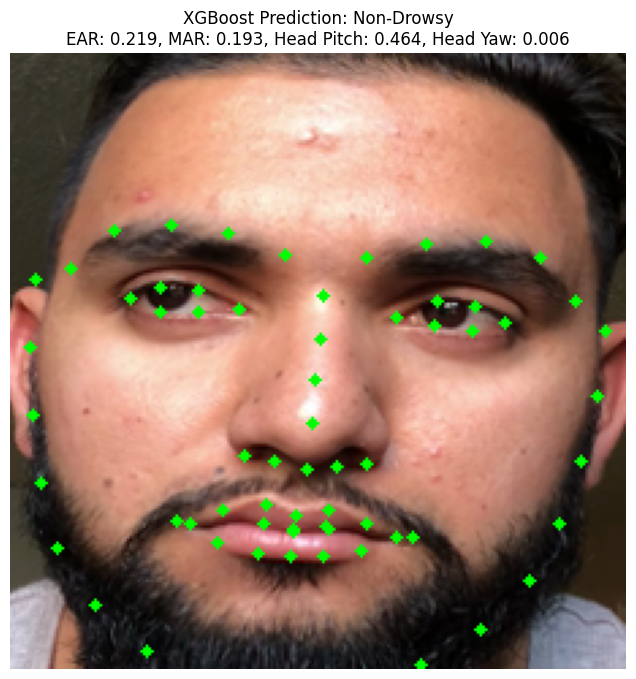

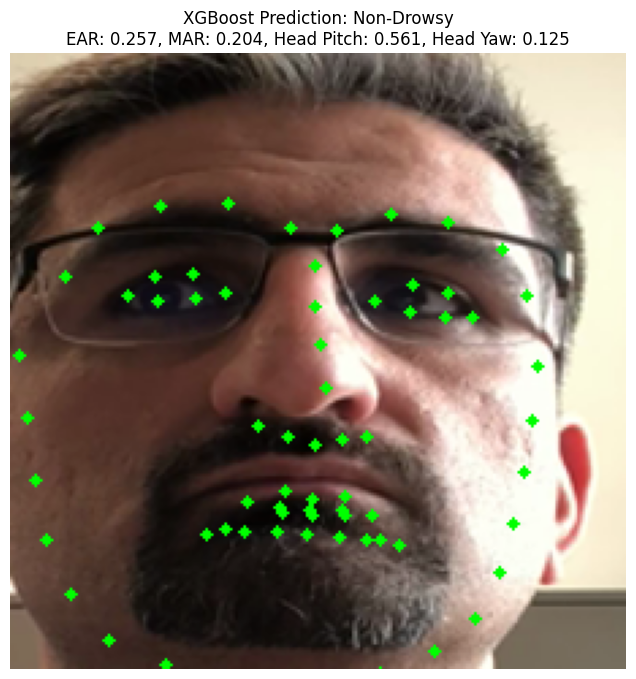

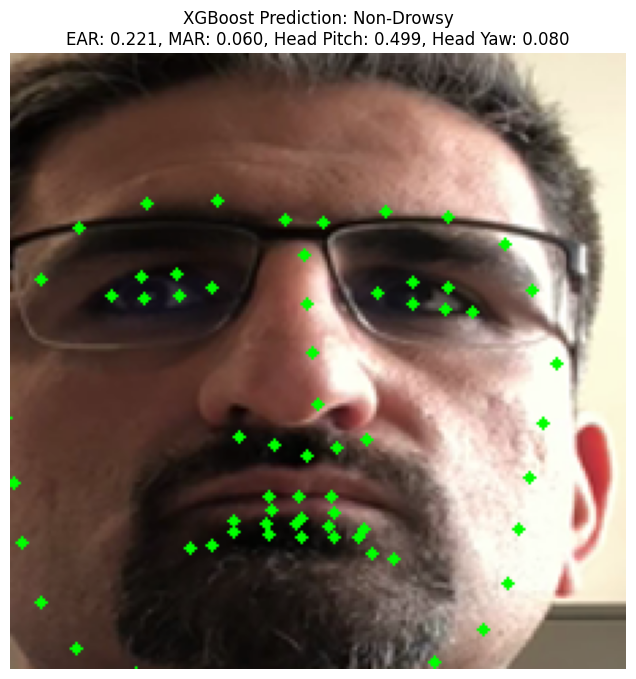

In [8]:
# Load XGBoost model
xgb_model = joblib.load("../outputs/models/xgboost/focused_xgb_model.joblib")

# Test images
drowsy_samples = get_random_samples("../inputs/datasets/raw/drowsy")
non_drowsy_samples = get_random_samples("../inputs/datasets/raw/non_drowsy")
test_images = drowsy_samples + non_drowsy_samples


for img_path in test_images:
    # Detect landmarks
    image, points = detect_landmarks(img_path)
    if image is None:
        continue

    # Calculate features
    face_width = distance.euclidean(points[0], points[16])
    left_ear = calculate_eye_aspect_ratio(points[36:42])
    right_ear = calculate_eye_aspect_ratio(points[42:48])
    avg_ear = (left_ear + right_ear) / 2.0
    ear_diff = abs(left_ear - right_ear)
    mar = calculate_mouth_aspect_ratio(points[48:68])

    # Calculate head pose features
    nose_tip, chin = points[30], points[8]
    head_pitch = distance.euclidean(nose_tip, chin) / face_width
    left_dist = distance.euclidean(points[0], points[27])
    right_dist = distance.euclidean(points[16], points[27])
    head_yaw = abs(left_dist - right_dist) / face_width
    emr = avg_ear / (mar + 0.01)

    # Prepare features for prediction
    features = np.array(
        [left_ear, right_ear, avg_ear, ear_diff, mar, head_pitch, head_yaw, emr]
    ).reshape(1, -1)

    prediction = xgb_model.predict(features)[0]

    # Display results
    title = (
        f"XGBoost Prediction: {'Drowsy' if prediction == 1 else 'Non-Drowsy'}\n"
        f"EAR: {avg_ear:.3f}, MAR: {mar:.3f}, Head Pitch: {head_pitch:.3f}, Head Yaw: {head_yaw:.3f}"
    )
    plot_image_with_title(image, title)

/Users/heetpatel/Desktop/drowsiness_detection_h/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/heetpatel/Desktop/drowsiness_detection_h/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


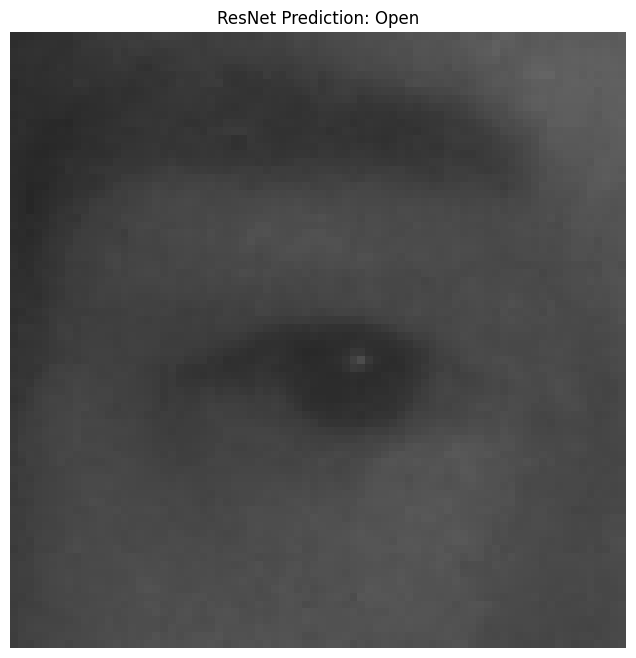

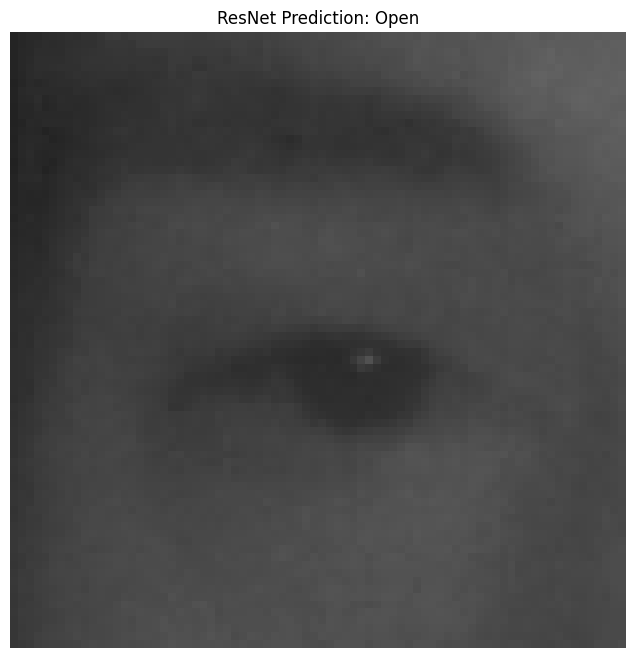

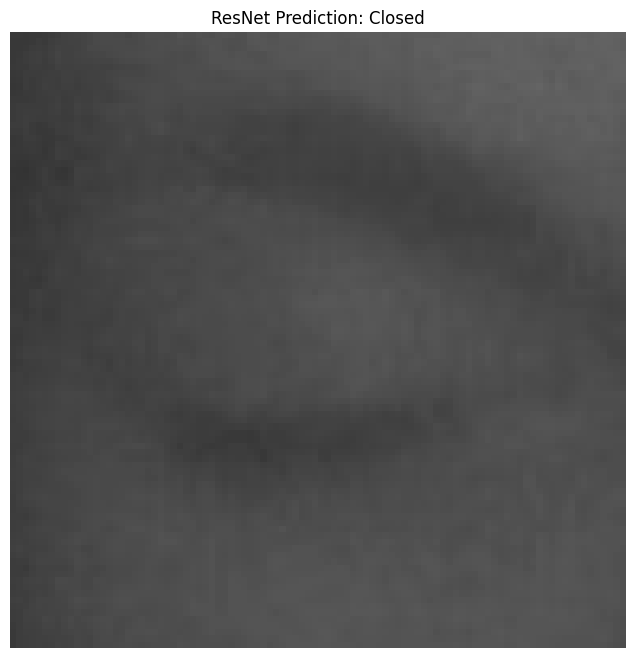

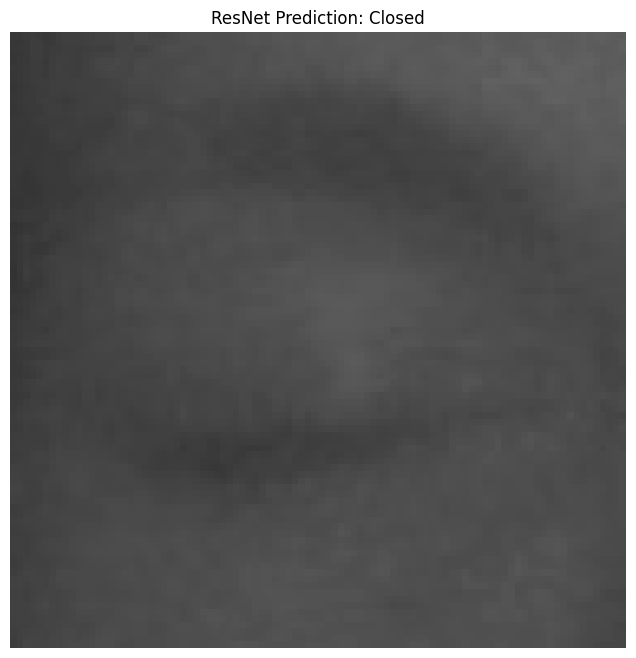

In [11]:
class EyesModel(nn.Module):
    def __init__(self, num_classes=2):
        super(EyesModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)


# Load ResNet model
resnet_model = EyesModel()
resnet_model.load_state_dict(torch.load("../outputs/models/resnet/best_eyes_model.pth"))
resnet_model.eval()

open_eyes_samples = get_random_samples("../inputs/datasets/eyes_data/test/open eyes")
close_eyes_samples = get_random_samples("../inputs/datasets/eyes_data/test/close eyes")
test_images = open_eyes_samples + close_eyes_samples

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

for img_path in test_images:
    # Load and transform image
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)

    # Get prediction
    with torch.no_grad():
        output = resnet_model(input_tensor)
        prediction = torch.argmax(output, dim=1).item()

    # Display results
    plt.figure(figsize=(10, 8))
    plt.imshow(np.array(image))
    plt.title(f"ResNet Prediction: {'Open' if prediction == 1 else 'Closed'}")
    plt.axis("off")
    plt.show()

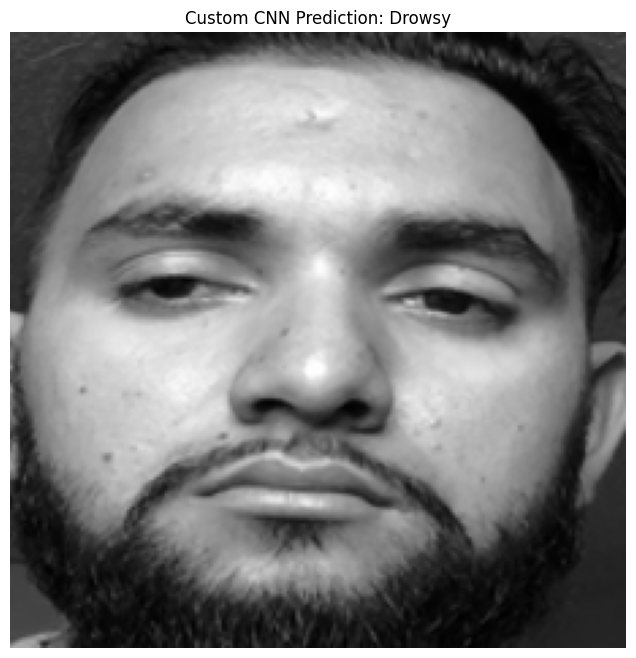

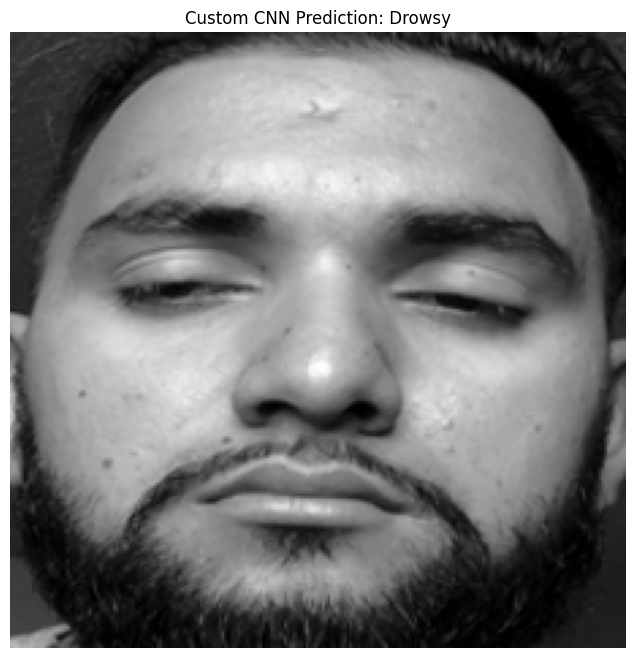

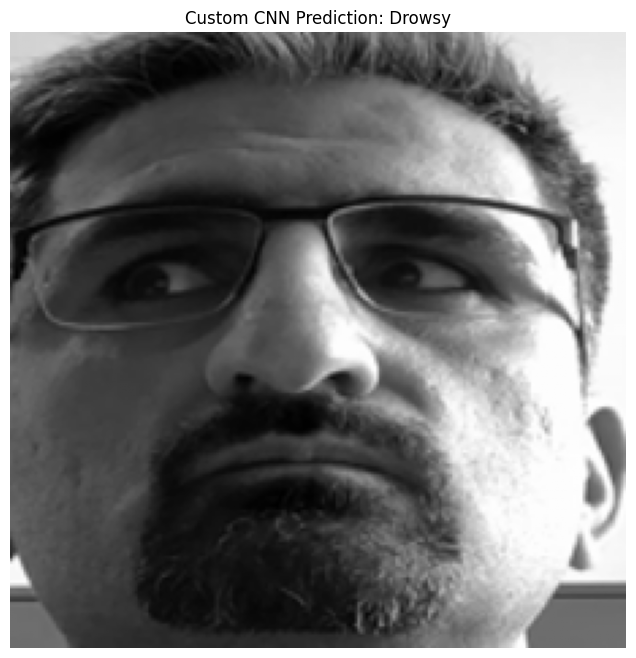

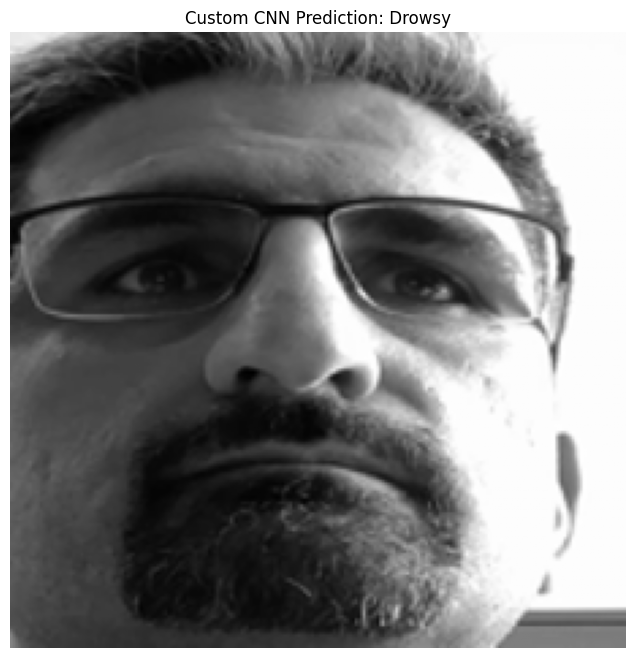

In [10]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Conv layers with correct filter sizes
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(2, 2)

        # FC layers with correct dimensions
        self.fc1 = nn.Linear(
            32 * 7 * 28, 64
        )  # Adjust input size based on your image dimensions
        self.bn4 = nn.BatchNorm1d(64)

        self.fc2 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)

        self.fc3 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 32 * 7 * 28)  # Adjust flattening dimension

        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.bn5(self.fc2(x)))
        x = self.dropout(x)

        x = self.fc3(x)
        return x


# Load the complete checkpoint
checkpoint = torch.load("../outputs/models/deep_ml/TJM3_FINAL_20250504_230729.pt")

# Extract just the model state dict
model_state_dict = checkpoint["model_state_dict"]

# Load into model
cnn_model = CustomCNN()
cnn_model.load_state_dict(model_state_dict)
cnn_model.eval()

# Test images
drowsy_samples = get_random_samples("../inputs/datasets/raw/drowsy")
non_drowsy_samples = get_random_samples("../inputs/datasets/raw/non_drowsy")
test_images = drowsy_samples + non_drowsy_samples

transform = transforms.Compose(
    [
        transforms.Resize((56, 224)),
        transforms.Grayscale(1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

for img_path in test_images:
    # Load and transform image
    image = Image.open(img_path).convert("L")
    input_tensor = transform(image).unsqueeze(0)

    # Get prediction
    with torch.no_grad():
        output = cnn_model(input_tensor)
        prediction = torch.argmax(output, dim=1).item()

    # Display results
    plt.figure(figsize=(10, 8))
    plt.imshow(np.array(image), cmap="gray")
    plt.title(f"Custom CNN Prediction: {'Drowsy' if prediction == 1 else 'Non-Drowsy'}")
    plt.axis("off")
    plt.show()